In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import os
import sys
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image
import torchvision.transforms as transforms

from IPython.display import display

sys.path.append('../../src/')
import modeling_utils
import models
import optimization_utils

In [2]:
# why did I put this here? Hoppefully makes it run faster!
torch.backends.cudnn.benchmark = True

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.__version__

'1.7.1+cu110'

## Hyperparamaters

In [5]:
NOISE_SIZE = 512
GRAD_PEN_WEIGHT = 10
MAX_DEPTH = 6
FADE_IN_PCT = .5
IMG_SIZE = 128
BATCH_SIZES = [128, 128, 128, 64, 32, 16]

In [6]:
epochs = [4,8,16,16,32,48]

## Load the data, and get some information from it

In [7]:
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(.5),
    transforms.ToTensor(),
])

In [8]:
sizes = [2**i for i in range(2, int(1+np.log(IMG_SIZE) / np.log(2)))]

In [9]:
sizes

[4, 8, 16, 32, 64, 128]

In [10]:
BATCH_SIZES = {size : bs for size, bs in zip(sizes, BATCH_SIZES)}

In [11]:
img_path = '../../data/modeling_%d/images/'
label_dicts = {size : {i: img_path%size + f for i, f in enumerate(os.listdir(img_path%size))} for size in sizes}

In [12]:
datasets = {}
for k, v in label_dicts.items():
    datasets[k] = modeling_utils.BirdDataset(v, transform=data_transform)

In [13]:
data_loaders = {}
for k, v in label_dicts.items():
    data_loaders[k] = torch.utils.data.DataLoader(datasets[k], batch_size=BATCH_SIZES[k], num_workers=0, shuffle=True, pin_memory=True)

0.0 1.0


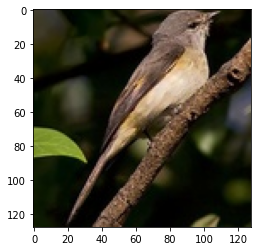

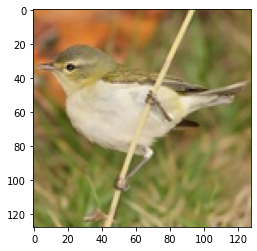

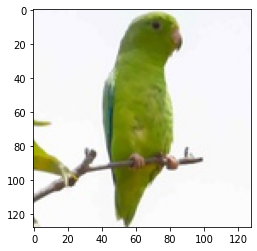

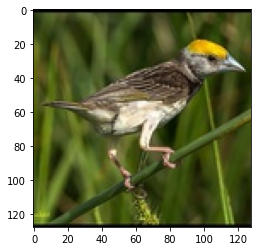

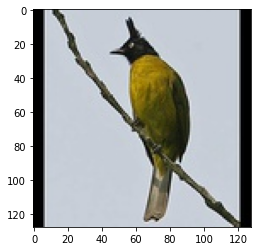

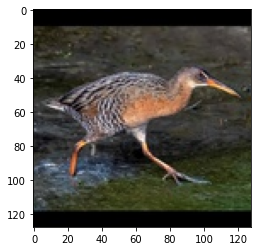

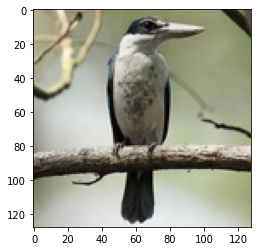

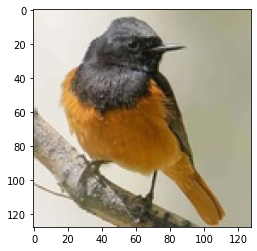

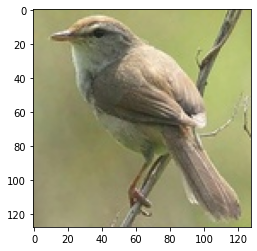

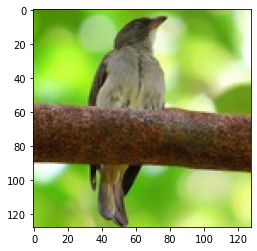

In [14]:
for batch in data_loaders[128]:
    batch = modeling_utils.swap_channels_batch(batch.data.cpu().numpy())
    print(batch.min(), batch.max())
    for i in range(10):
        plt.imshow(batch[i])
        plt.show()
    break

In [15]:
device = torch.device('cuda')

In [16]:
FIXED_NOISE = modeling_utils.generate_noise(16, NOISE_SIZE, device)

In [17]:
FIXED_NOISE[0].size(), FIXED_NOISE[1].size()

(torch.Size([512]), torch.Size([512]))

### Models themselves

# TODO: Pick good learning rates!!!!!

In [18]:
save_path = './big_run/'

In [19]:
gen = models.StyleGanGenerator(MAX_DEPTH, NOISE_SIZE).to(device)
gen_opt = optim.Adam([{'params': gen.mapping_layers.parameters(), 'lr':1e-5}, 
                      {'params': gen.synthesis_layers.parameters()},
                      {'params': gen.truncation.parameters()}], betas=(0, .99))
gen_ema = copy.deepcopy(gen)
optimization_utils.update_average(gen_ema, gen, 0)

In [20]:
discrim = models.StyleGanDiscriminator(MAX_DEPTH, NOISE_SIZE).to(device)
discrim_opt = optim.Adam(discrim.parameters(), betas=(0, .99))

In [21]:
depth = 5
load_fade_in = 100
load_step = 630
gen.load_state_dict(torch.load(save_path + 'models/gen_depth_%d_fade_%d_step_%d.pt'%(depth, load_fade_in, load_step)))
gen_ema.load_state_dict(torch.load(save_path + 'models/gen_ema_depth_%d_fade_%d_step_%d.pt'%(depth, load_fade_in, load_step)))
discrim.load_state_dict(torch.load(save_path + 'models/discrim_depth_%d_fade_%d_step_%d.pt'%(depth, load_fade_in, load_step)))
gen_opt.load_state_dict(torch.load(save_path + 'models/gen_opt_depth_%d_fade_%d_step_%d.pt'%(depth, load_fade_in, load_step)))
discrim_opt.load_state_dict(torch.load(save_path + 'models/discrim_opt_depth_%d_fade_%d_step_%d.pt'%(depth, load_fade_in, load_step)))
FIXED_NOISE=torch.tensor(np.load(save_path + 'fixed_samples/fixed_noise.npy'), dtype=torch.float, device=device)

### Optimization steps

In [22]:
loss_fn = "log_r1_batch"

In [2]:
# Keep fid=False. Calculating covariance hangs sometimes for some reason?

In [ ]:
# optimization_utils.train_on_depth_progan(gen, gen_opt, gen_ema, discrim, discrim_opt, depth=0, nb_epochs=epochs[0], 
#                                                 fade_in_pct=FADE_IN_PCT, loader = data_loaders[4], device=device, 
#                                                  noise_size=NOISE_SIZE, grad_pen_weight=GRAD_PEN_WEIGHT, loss=loss_fn,
#                                                  checkpoint_interval=.25, save_dir=save_path, 
#                                                  print_metrics=False, fixed_noise=FIXED_NOISE, plot_gen_samples=False,
#                                                  save_gen_samples=True, save_gen_fixed=True, tensorboard=True, fid=False,
#                                         fid_real_path = '../../data/modeling_256/images/')

In [ ]:
# optimization_utils.train_on_depth_progan(gen, gen_opt, gen_ema, discrim, discrim_opt, depth=1, nb_epochs=epochs[1], 
#                                                 fade_in_pct=FADE_IN_PCT, loader = data_loaders[8], device=device, 
#                                                  noise_size=NOISE_SIZE, grad_pen_weight=GRAD_PEN_WEIGHT, loss=loss_fn,
#                                                  checkpoint_interval=.25, save_dir=save_path, 
#                                                  print_metrics=False, fixed_noise=FIXED_NOISE, plot_gen_samples=False,
#                                                  save_gen_samples=True, save_gen_fixed=True, tensorboard=True, fid=False,
#                                         fid_real_path = '../../data/modeling_256/images/')

In [ ]:
# optimization_utils.train_on_depth_progan(gen, gen_opt, gen_ema, discrim, discrim_opt, depth=2, nb_epochs=epochs[2], 
#                                                 fade_in_pct=FADE_IN_PCT, loader = data_loaders[16], device=device, 
#                                                  noise_size=NOISE_SIZE, grad_pen_weight=GRAD_PEN_WEIGHT, loss=loss_fn,
#                                                  checkpoint_interval=.25, save_dir=save_path, 
#                                                  print_metrics=False, fixed_noise=FIXED_NOISE, plot_gen_samples=False,
#                                                  save_gen_samples=True, save_gen_fixed=True, tensorboard=True, fid=False,
#                                         fid_real_path = '../../data/modeling_256/images/')

In [ ]:
# optimization_utils.train_on_depth_progan(gen, gen_opt, gen_ema, discrim, discrim_opt, depth=3, nb_epochs=epochs[3], 
#                                                 fade_in_pct=FADE_IN_PCT, loader = data_loaders[32], device=device, 
#                                                  noise_size=NOISE_SIZE, grad_pen_weight=GRAD_PEN_WEIGHT, loss=loss_fn,
#                                                  checkpoint_interval=.25, save_dir=save_path, 
#                                                  print_metrics=False, fixed_noise=FIXED_NOISE, plot_gen_samples=False,
#                                                  save_gen_samples=True, save_gen_fixed=True, tensorboard=True, fid=False,
#                                         fid_real_path = '../../data/modeling_256/images/')

In [ ]:
# optimization_utils.train_on_depth_progan(gen, gen_opt, gen_ema, discrim, discrim_opt, depth=4, nb_epochs=epochs[4], 
#                                                 fade_in_pct=FADE_IN_PCT, loader = data_loaders[64], device=device, 
#                                                  noise_size=NOISE_SIZE, grad_pen_weight=GRAD_PEN_WEIGHT, loss=loss_fn,
#                                                  checkpoint_interval=.25, save_dir=save_path, 
#                                                  print_metrics=False, fixed_noise=FIXED_NOISE, plot_gen_samples=False,
#                                                  save_gen_samples=True, save_gen_fixed=True, tensorboard=True, fid=False,
#                                         fid_real_path = '../../data/modeling_256/images/')

In [ ]:
# optimization_utils.train_on_depth_progan(gen, gen_opt, gen_ema, discrim, discrim_opt, depth=5, nb_epochs=epochs[5], 
#                                                 fade_in_pct=FADE_IN_PCT, loader = data_loaders[128], device=device, 
#                                                  noise_size=NOISE_SIZE, grad_pen_weight=GRAD_PEN_WEIGHT, loss=loss_fn,
#                                                  checkpoint_interval=.25, save_dir=save_path, 
#                                                  print_metrics=False, fixed_noise=FIXED_NOISE, plot_gen_samples=False,
#                                                  save_gen_samples=True, save_gen_fixed=True, tensorboard=True, fid=False,
#                                         fid_real_path = '../../data/modeling_256/images/')

In [23]:
optimization_utils.train_on_depth_progan(gen, gen_opt, gen_ema, discrim, discrim_opt, depth=5, nb_epochs=4, 
                                                fade_in_pct=-1, loader = data_loaders[128], device=device, 
                                                 noise_size=NOISE_SIZE, grad_pen_weight=GRAD_PEN_WEIGHT, loss=loss_fn,
                                                 checkpoint_interval=.25, save_dir=save_path, 
                                                 print_metrics=False, fixed_noise=FIXED_NOISE, plot_gen_samples=False,
                                                 save_gen_samples=True, save_gen_fixed=True, tensorboard=True, fid=False,
                                        fid_real_path = '../../data/modeling_256/images/')

In [1]:
# Additional epochs trained (After initial 48): 32

In [ ]:
modeling_utils.plot_imgs(modeling_utils.sample_gen_images(gen_ema, NOISE_SIZE, device, depth=5, alpha=1))

In [ ]:
modeling_utils.plot_imgs(modeling_utils.sample_gen_images(gen_ema, NOISE_SIZE, device, depth=5, alpha=1))

In [ ]:
modeling_utils.plot_imgs(modeling_utils.sample_gen_images(gen_ema, NOISE_SIZE, device, depth=5, alpha=1))

In [ ]:
modeling_utils.plot_imgs(modeling_utils.sample_gen_images(gen_ema, NOISE_SIZE, device, depth=5, alpha=1))

In [ ]:
modeling_utils.plot_imgs(modeling_utils.sample_gen_images(gen_ema, NOISE_SIZE, device, depth=5, alpha=1))

In [ ]:
modeling_utils.plot_imgs(modeling_utils.sample_gen_images(gen_ema, NOISE_SIZE, device, depth=5, alpha=1))

In [ ]:
modeling_utils.plot_imgs(modeling_utils.sample_gen_images(gen_ema, NOISE_SIZE, device, depth=5, alpha=1))